In [133]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [134]:
from lessons_functions import *

In [156]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

img = mpimg.imread('test_images/test4.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, step, ysteps):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,450:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = ysteps#nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Search for bounding boxes
    bboxes = []
    
    for xb in range(nxsteps + 1):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
          
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))  
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale) + 450
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bboxes.append(bbox)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bboxes


def visualize_bboxes(img, ystart, ystop, scale, pix_per_cell, cell_per_block, step, ystep):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) + 2# - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell)# - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = ystep#(nyblocks - nblocks_per_window) // cells_per_step
    
    bboxes = []
    
    for xb in range(nxsteps + 4):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
          
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            bbox = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
            bboxes.append(bbox)
            
    return bboxes
            
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [192]:
from scipy.ndimage.measurements import label

svc = pickle.load( open("svc_pickle.p", "rb" ) )
X_scaler = pickle.load( open("scaler_pickle.p", "rb" ) )
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 32
ystarts = [390,  400,  410,  390]
ystops =  [656,  656,  656,  656]
scales =  [1.0,  1.8,  2.6,  3.5]
steps =   [2,    2,    2,    2]
ysteps =   [3,   3,    2,    1]

memory = []
frame_no = 0

def clean_memory():
    global memory
    global frame_no
    memory = []
    frame_no = 0

def pipeline(img, memory_size=2):
    global memory
    global frame_no 
    
    # change this line to skip frames
    if frame_no % 1 == 0:
        bboxes = []
    
        for scale, ystart, ystop, step, ystep in zip(scales, ystarts, ystops, steps, ysteps):
            new_bboxes = find_cars(
                img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, step, ystep)
            bboxes.extend(new_bboxes)
    
        memory.append(bboxes)
        if len(memory) > memory_size:
            memory = memory[1:]
    
    frame_no += 1
     
    # create heat maps
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    flatten = [v for sublist in memory for v in sublist]
    heat = add_heat(heat, flatten)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

CPU times: user 62.6 ms, sys: 2.56 ms, total: 65.1 ms
Wall time: 65.2 ms


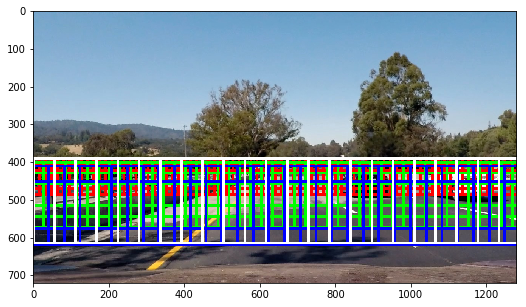

In [189]:
image = mpimg.imread('test_images/test4.jpg')
image = cv2.resize(image, (1280, 720))
clean_memory()

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 255)]

plt.figure(figsize=(15,5))

for scale, ystart, ystop, step, c, ystep in zip(scales, ystarts, ystops, steps, colors, ysteps):
    bboxes = visualize_bboxes(image, ystart, ystop, scale, 8, 2, 2, ystep)
    for bbox in bboxes:
        cv2.rectangle(image, bbox[0], bbox[1], c, 6)

%time plt.imshow(image)

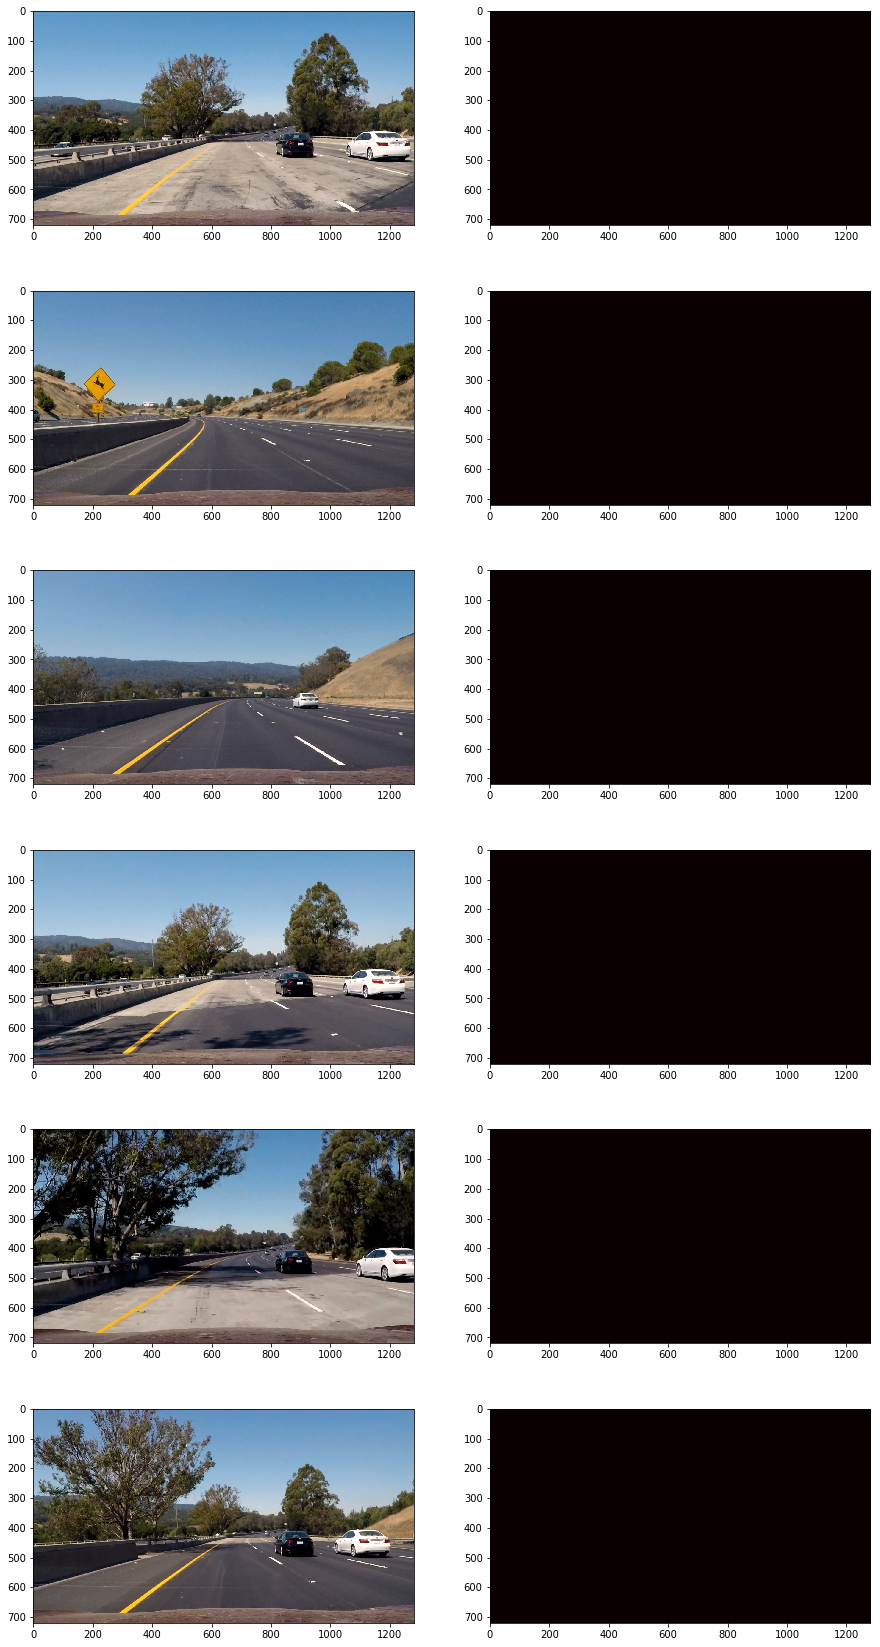

In [193]:
from glob import glob
test_files = sorted(glob("test_images/*.jpg"))

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
for i, t_file in enumerate(test_files):
    clean_memory()
    image = mpimg.imread(t_file)
    image = cv2.resize(image, (1280, 720))
    draw_img, heatmap = pipeline(image, 1)
    plt.subplot(6, 2, i*2 + 1)
    plt.imshow(draw_img)
    plt.subplot(6, 2, i*2 + 2)
    plt.imshow(heatmap, cmap='hot')

In [191]:
from moviepy.editor import VideoFileClip
clean_memory()
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) 
%time white_clip.write_videofile("project_output.mp4", audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [32:20<00:01,  1.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 31min 55s, sys: 23.9 s, total: 32min 19s
Wall time: 32min 21s
